# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

- Подготовить данmные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам pandas, matplotlib и sklearn. Вам поможет их документация.
Следующий урок посвящён технологическому процессу очистки руды. Решите сами, какие детали нужны для построения модели, а какие — нет.


## Описание данных

### Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


### Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


### Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики





In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score, KFold, LeavePGroupsOut, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

### Глобальные переменные

In [3]:
SEED = 42

## Подготовка данных

In [4]:
def checkDatasets(filename):
    df = pd.read_csv(filename, index_col='date')
    
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

    display(df.head())

    display(df.info())

    display(df.describe().T)

    print("Количество дубликатов")
    display(df.duplicated().sum())

    print("Список дубликатов")
    display(df[df.duplicated(keep=False)].sort_values(by='date'))

    return df

In [5]:
df = checkDatasets('/datasets/gold_recovery_full_new.csv')

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

None

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final.output.concentrate_sol,19228.0,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final.output.recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,19438.0,-488.684065,34.533396,-797.323986,-500.458467,-499.802605,-498.384187,-244.483566
secondary_cleaner.state.floatbank5_b_air,19438.0,12.198224,5.333024,0.528083,8.971105,11.019433,14.019088,27.926001
secondary_cleaner.state.floatbank5_b_level,19438.0,-487.149827,38.347312,-800.220337,-500.129462,-499.935317,-499.436708,-137.740004
secondary_cleaner.state.floatbank6_a_air,19437.0,18.959024,5.550498,-0.079426,14.983037,19.960541,24.003170,32.188906


Количество дубликатов


0

Список дубликатов


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,


In [6]:
test_df = checkDatasets('/datasets/gold_recovery_test_new.csv')

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

None

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


Количество дубликатов


0

Список дубликатов


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,


In [7]:
train_df = checkDatasets('/datasets/gold_recovery_train_new.csv')

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

None

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.000000,4.211620,4.994652,5.859540,16.001945
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.000000,9.297355,10.297144,11.170603,17.031899
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.000000,7.484645,8.845462,10.487508,18.124851
final.output.concentrate_au,14149.0,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final.output.recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,14148.0,-483.956022,37.892788,-797.142475,-500.363177,-499.702452,-487.712108,-275.073125
secondary_cleaner.state.floatbank5_b_air,14148.0,13.064590,5.765617,0.646208,8.994405,11.997547,17.982903,27.926001
secondary_cleaner.state.floatbank5_b_level,14148.0,-483.966564,39.207913,-800.006180,-500.105994,-499.914556,-453.186936,-157.396071
secondary_cleaner.state.floatbank6_a_air,14147.0,19.577539,5.764417,0.195324,14.989304,19.984175,24.991623,32.188906


Количество дубликатов


0

Список дубликатов


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,


Убедимся что ничего не пропало

In [8]:
print(df.shape, train_df.shape, test_df.shape, sep='\n')
print(df.shape[0], train_df.shape[0] + test_df.shape[0])

(19439, 86)
(14149, 86)
(5290, 52)
19439 19439


Ура, нас не пропали строки, в тесте нет части столбцов

Посмотрим как расположены по времени трейн и тест

In [9]:
def drow_line(data, n, qnt=100):
    
    x = data.index[::qnt]
    return x, [n]*len(x)

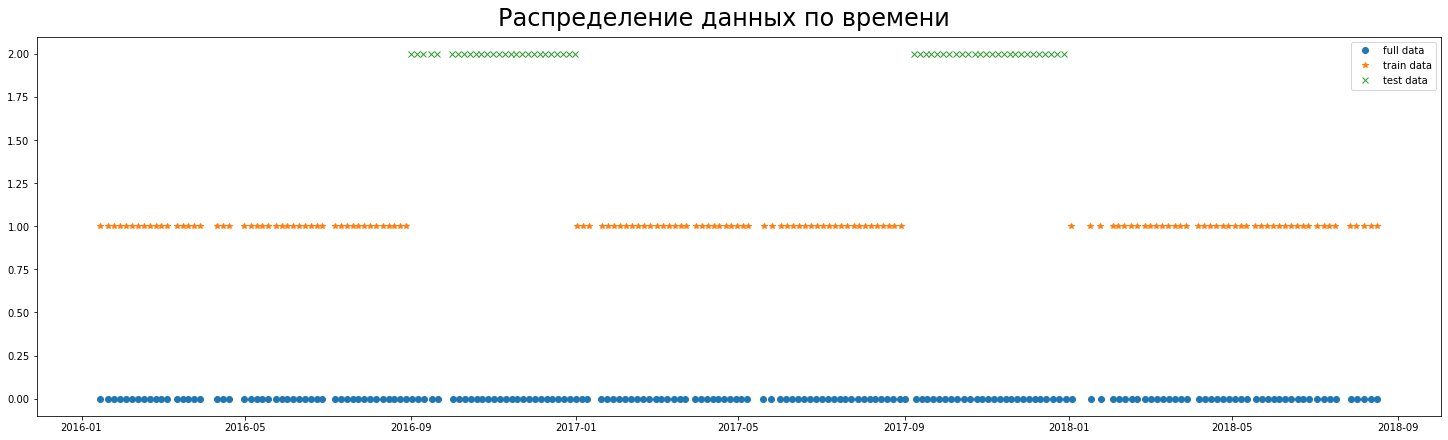

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Распределение данных по времени', fontsize=24)

ax.plot(*drow_line(df, 0), 'o')
ax.plot(*drow_line(train_df, 1), '*')
ax.plot(*drow_line(test_df, 2),  'x')
# ax.plot(train_df.index[::100])
# ax.plot(test_df.index[::100])
plt.legend(['full data', 'train data', 'test data'])
plt.show()

Данные распредлены равномерно по времени, данные для теста взяты не рандомно, а как два связанных отрезка

### Проверка формулы вычисления эффективности обогащения

Напомним себе:

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

напишем функцию

In [11]:
def recovery(c, f, t):
    """
    Производит расчет эффективности обогащения

    :param c: доля золота в концентрате после флотации/очистки;
    :param f: доля золота в сырье/концентрате до флотации/очистки;
    :param f: доля золота в отвальных хвостах после флотации/очистки.

    :return: эффективность обогащения в процентах
    """
    
    return (c * (f - t)) / (f * (c - t)) * 100

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Расчёт верный!</font>

In [12]:
recovery_prediction = recovery(
        train_df['rougher.output.concentrate_au'], 
        train_df['rougher.input.feed_au'],
        train_df['rougher.output.tail_au']
)

correct_recovery_count = np.isclose(recovery_prediction, train_df['rougher.output.recovery']).sum()
print(f"Количество корректных предсказаний: {correct_recovery_count}")
print(f"Количество некорректных предсказаний: {train_df.shape[0]-correct_recovery_count}")

print(f"Средняя абсолютная ошибка: {mean_absolute_error(train_df['rougher.output.recovery'], recovery_prediction)}")  

Количество корректных предсказаний: 14149
Количество некорректных предсказаний: 0
Средняя абсолютная ошибка: 9.73512347450521e-15


### Анализ признаков, недоступных в тестовой выборке

In [13]:
full_data_columns = df.columns.to_list()
train_data_columns = train_df.columns.to_list()
test_data_columns = test_df.columns.to_list()

Признаки, которых нет в тестовой выборке

In [14]:
column_diff = set(train_data_columns) - set(test_data_columns)
column_diff

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке нет таргетов - `rougher.output.recovery` и `final.output.recovery`, что логично. Кроме этого нет большого количества промежуточных результатов - скорее все. Не будем их учитывать при  обучении модели.


Почему эти признаки не включены в тестовую выборку?

Посмотрим на корреляции этих признаков и `rougher.output.recovery` и `final.output.recovery`

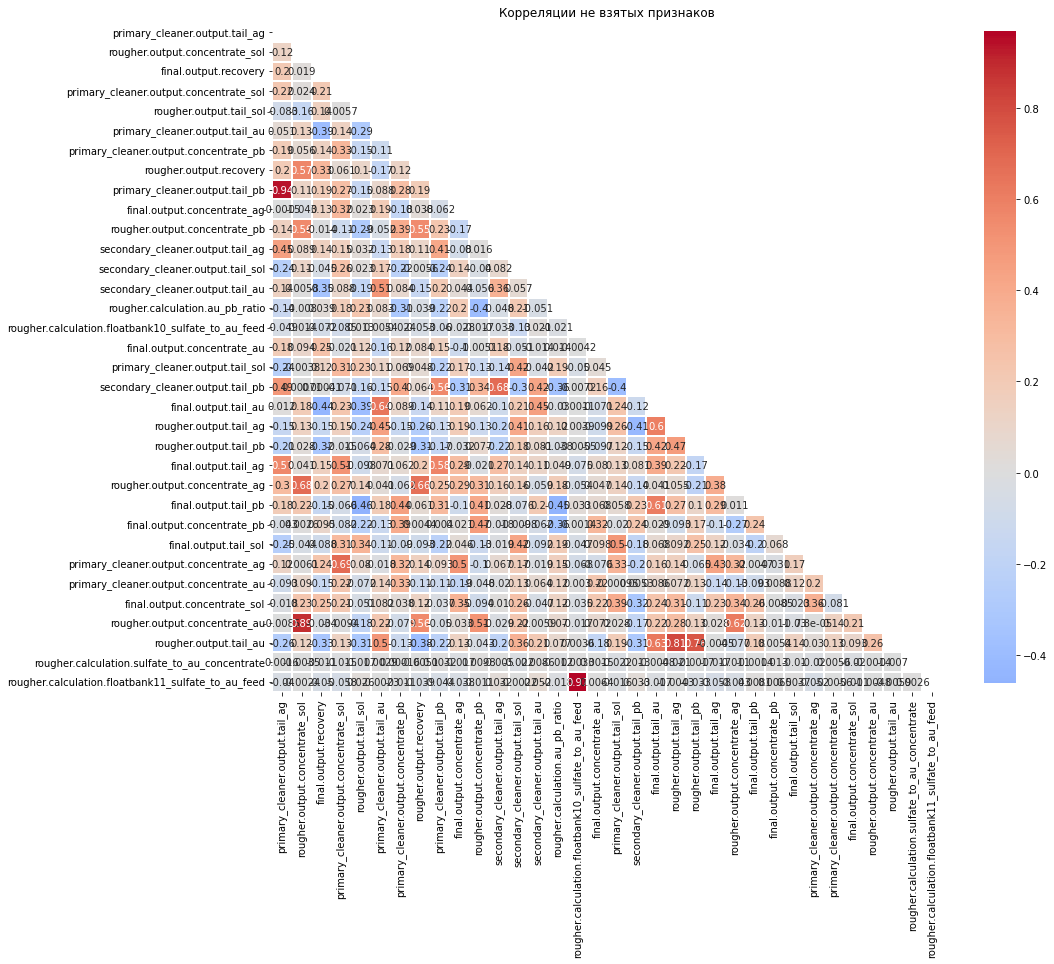

In [15]:
corr = train_df[list(column_diff)].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))


fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, center=0, cmap="coolwarm", square=True,
linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, mask=mask)
ax.set_title("Корреляции не взятых признаков")
plt.show()

Я надеялся тут увидеть высокую степень зависимости между таргетами и невзятыми признаками, что говорило бы о том что мы выкинули все эти признаки из-за фунуциональной связи с таргетом, или наоборот отсутствие взаимосвязи, что говорило бы о том что эти признаки нам никак не помогут в процессе построения модели. Но ни то ни другое не произошло)

Разделим переменные на два этапа, первый будет включать флотацию, второй - первичную и вторичную очистку.

## Анализ данных

###  Изменение концентрации элементов на каждом этапе


In [16]:
# Золото Серебро свинец
metals = ['au', 'ag', 'pb']

stages_concentrate = ['rougher.input.feed_', 'rougher.output.concentrate_','primary_cleaner.output.concentrate_', 'final.output.concentrate_',]
stages_tail = ['rougher.input.feed_', 'rougher.output.tail_','primary_cleaner.output.tail_', 'final.output.tail_',]

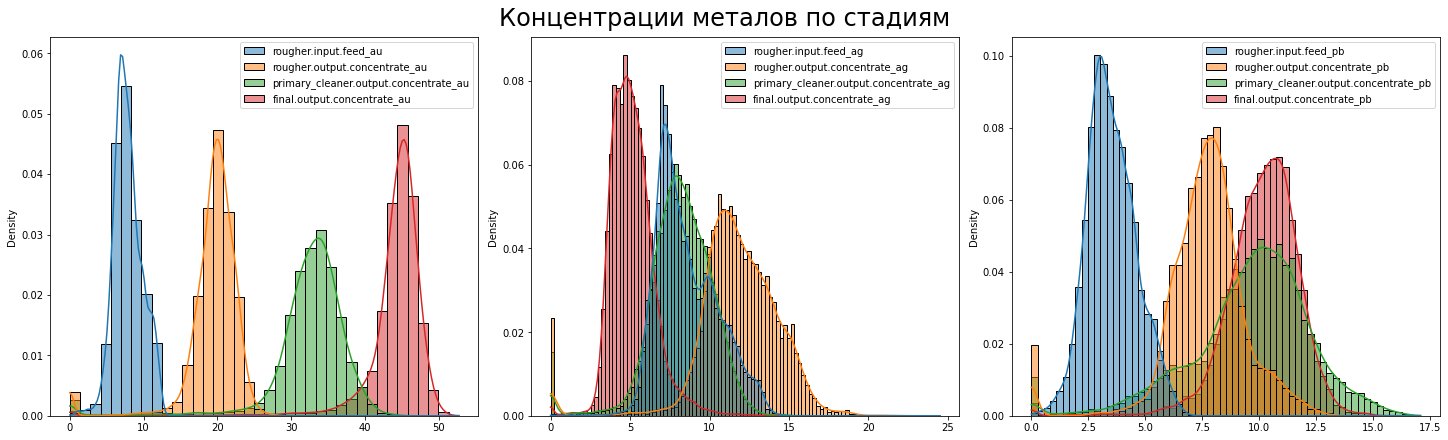

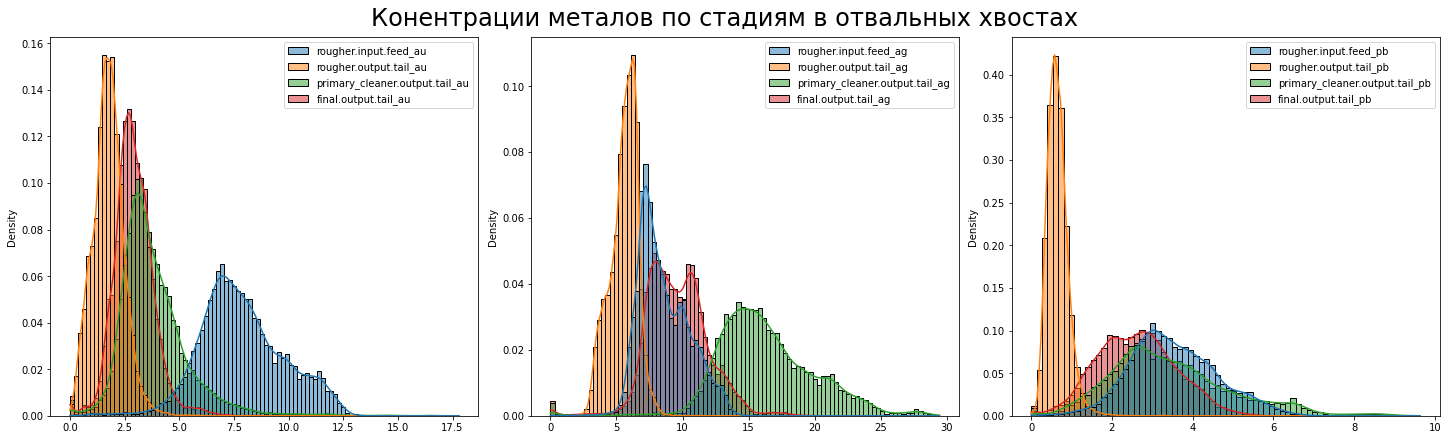

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрации металов по стадиям', fontsize=24)

for metal, ax in zip(metals, axs): 
    current_stage_name = [stage+metal for stage in stages_concentrate]
    sns.histplot(train_df[current_stage_name].dropna(), label=current_stage_name, ax=ax, kde=True, stat="density", linewidth=1) 


    

fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Конентрации металов по стадиям в отвальных хвостах', fontsize=24)

for metal, ax in zip(metals, axs): 
    current_stage_name = [stage+metal for stage in stages_tail]
    sns.histplot(train_df[current_stage_name].dropna(), label=current_stage_name, ax=ax, kde=True, stat="density", linewidth=1) 


plt.show()




- Концентрация золота в процессе очистки возрастает
- Концентрация серебра  в процессе очистки уменьшается
- Концентрация свинца в процессе очистки возрастает

В отвальных хвостах концентрации также растут, но медленне и распеределение 'расплывается' в процессе очистки



<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Всё верно!</font>

### Изменение размеров гранул на обучающей и тестовой выборках

In [18]:
size_column = ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

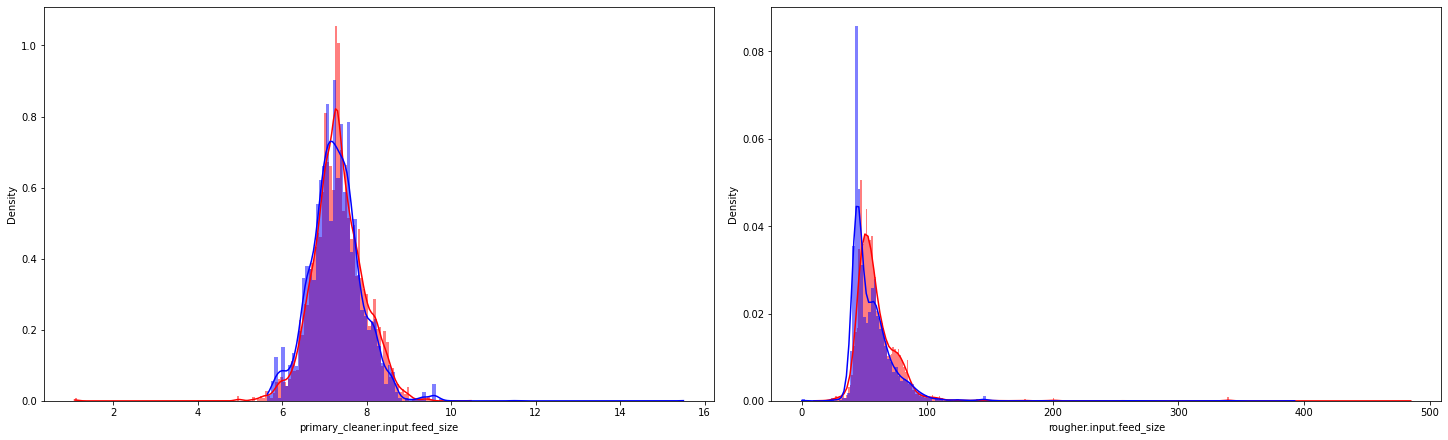

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)



for name,  ax in zip(size_column, axs):
    sns.histplot(train_df[name],  color='r', ax=ax, kde=True, stat="density", linewidth=0)
    sns.histplot(test_df[name],  color='b', ax=ax, kde=True, stat="density", linewidth=0)

plt.show()

Распределения практически совпадают, размер гранул на обучающей и тестовой выборках не меняется.

### Суммарные концентрации

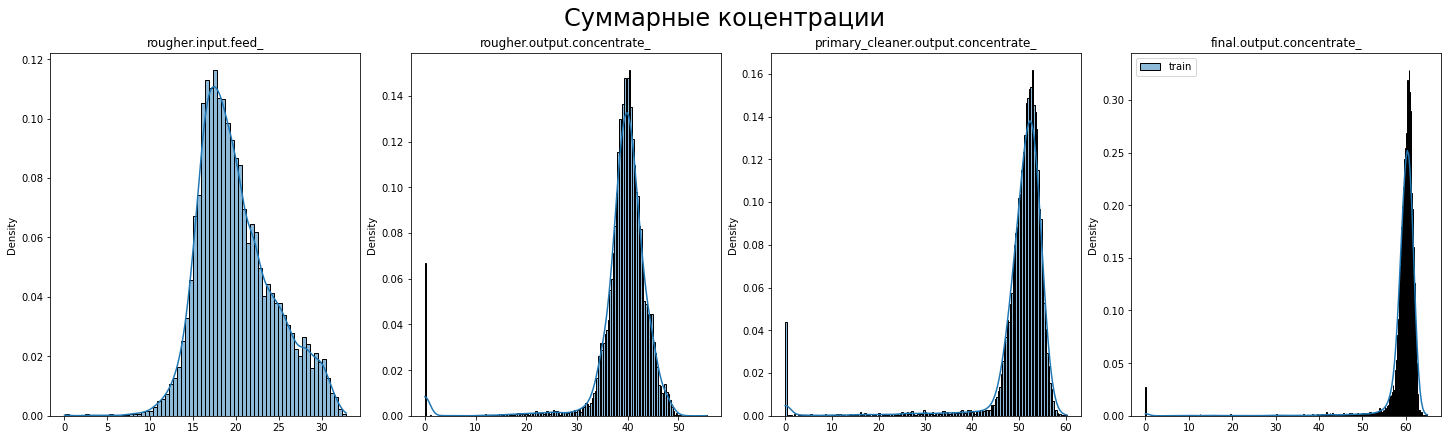

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Суммарные коцентрации', fontsize=24)

for stage, ax in zip(stages_concentrate, axs):
    ax.set_title(stage)
    sum_train = train_df[stage+ 'ag'] + train_df[stage+ 'au'] + train_df[stage+ 'pb']

    sns.histplot(sum_train.dropna(), label='train', ax=ax, kde=True, stat="density", linewidth=1) 

plt.legend()
plt.show()

Суммарные концентрации металов возрастают - очистка эффективна

У нас наблюдаюся выбросы в нуле - это означает что суммарная концентрация металлов равна 0. Это явная ошибка - скорее всего данные не заполнены или в процессе эксперимента что-то пошло не так.

Посмотрим сколько данных пусто.

In [21]:
metals = ['au', 'ag', 'pb']

mask_df = [False]*df.shape[0]
mask_train = [False]*train_df.shape[0]
for stage in stages_concentrate:
    ax.set_title(stage)
    names = [stage+metal for metal in metals]
    
    mask_df = mask_df | (df[names].sum(axis=1) == 0)
    mask_train = mask_train | (train_df[names].sum(axis=1) == 0)

print(df[mask_df].shape)  
print(train_df[mask_train].shape) 

(591, 86)
(424, 86)


In [22]:
test_mask = test_df.index.isin(df[mask_df].index)

591 плохое значение - это не так много. Отбросим их из исходных данных, трейна и теста.
Но перед этим поссмотрим когда именно лаборанты лажали)

Но если с полными данными все просто, то с трейном все сложнее

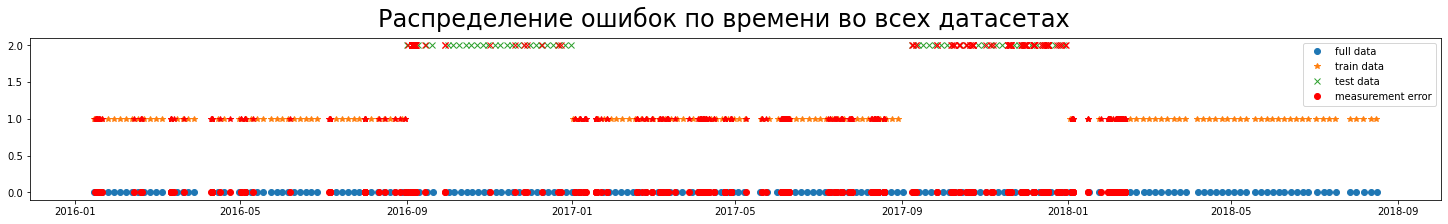

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20, 3), constrained_layout=True)
fig.suptitle('Распределение ошибок по времени во всех датасетах', fontsize=24)

ax.plot(*drow_line(df, 0), 'o')
ax.plot(*drow_line(train_df, 1), '*')
ax.plot(*drow_line(test_df, 2),  'x')

ax.plot(*drow_line(df[mask_df], 0, 1), 'o', c='r')
ax.plot(*drow_line(train_df[mask_train], 1, 1), '*',  c='r')
ax.plot(*drow_line(test_df[test_mask], 2, 1),  'x', c='r')


plt.legend(['full data', 'train data', 'test data', 'measurement error'])
plt.show()

В начале ошибок много, но после февраля 2018 они исчезают. Держу пари, один из лаборантов уволился!

Почистим данные

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

In [24]:
test_df = test_df.drop(test_df[test_df.index.isin(df[mask_df].index)].index)

train_df = train_df.drop(train_df[mask_train].index)

df =  df.drop(df[mask_df].index)

Проведем контроль: 

In [25]:
print(df.shape, train_df.shape, test_df.shape, sep='\n')
print(df.shape[0], train_df.shape[0] + test_df.shape[0])

(18848, 86)
(13725, 86)
(5123, 52)
18848 18848


Все ок, почистили аккуратно.

## Модель


### Метрики

In [26]:
def smape(target, prediction):
    """
    Производит расчет sMAPE (англ. Symmetric Mean Absolute Percentage Error)

    :param prediction: значение предсказания в тестовой выборке;
    :param target: значение целевого признака в выборке, на которой измеряется качество;

    :return: sMAPE
    """      
    
    numerator = np.abs(target-prediction)
    denominator =(np.abs(target)+np.abs(prediction))/2
    
    div_output = np.divide(numerator, denominator)
    
    
    output_scores = np.average(div_output[denominator != 0], axis=0)
    
    return  100 * output_scores

In [27]:
def final_smape(target, prediction): 
    return np.abs(0.25*smape(target.to_numpy()[:,0], prediction[:,0]) + 0.75*smape(target.to_numpy()[:,1], prediction[:,1]))

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> `smape` и `final_smape` расчитаны верно.</font>

In [28]:
smape_score = make_scorer(smape, greater_is_better=False)
final_smape_score = make_scorer(final_smape, greater_is_better=False)

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️ <br>
<font color='green'>Верно, что не забываешь указать greater_is_better=False, Это пригодится для SearchCV. SMAPE — ошибка, её минимизируем.</font>

### Заполнение пропусков

In [29]:
test_df = test_df.fillna(method="ffill")
train_df = train_df.fillna(method="ffill")
df = df.fillna(method="ffill")

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Такое решение допустимо. но мы теряем данные.\
В условиях есть указание, что соседние данные похожи. Можно протестировать работу моделей с заполнением по этому условию.</font>

<font color='purple'><b>Комментарий студента
     
Поправил, спасибо за замечание 
    
</b></font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

### Разобьем данные на трейн и тест:

In [30]:
train_data = train_df.drop(column_diff, axis=1)
train_target = train_df[['rougher.output.recovery', 'final.output.recovery']]

In [31]:
test_data = test_df
test_target = df[df.index.isin(test_df.index)][['rougher.output.recovery', 'final.output.recovery']]

Разобьем данные по этапам

In [32]:
# собираем признаки для этапа флотации
rougher_column = [name for name in train_data.columns if name.startswith("rougher")]

# собираем признаки для этапа очистки
cleaner_column = [name for name in train_data.columns if (name.startswith("primary_cleaner") or name.startswith("secondary_cleaner"))]

In [33]:
train_data.columns.size, len(rougher_column), len(cleaner_column)

(52, 22, 30)

В процессе разбиения ничего не потеряно

In [34]:
train_data_rougher = train_data[rougher_column]
train_target_rougher= train_target['rougher.output.recovery']

train_data_cleaner = train_data[cleaner_column]
train_target_cleaner= train_target['final.output.recovery']

In [35]:
test_data_rougher = test_data[rougher_column]
test_target_rougher= test_target['rougher.output.recovery']

test_data_cleaner = test_data[cleaner_column]
test_target_cleaner= test_target['final.output.recovery']

In [36]:
set(train_data.columns) - set(train_data_rougher.columns) - set(train_data_cleaner.columns)

set()

## Построение модели

Посмотрим на таргеты:
- `rougher.output.recovery` - эффективность обогащения чернового концентрата в результате этапа флотации
- `final.output.recovery` - эффективность обогащения финального концентрата в результате первого и торого этапа очистки

Для предсказания `rougher.output.recovery` нам нужны данные только этапа флотации c префиксом `rougher`
Для предсказания `final.output.recovery` нам нужны данные этапов primary_cleaner (первичная очистка) и secondary_cleaner (вторичная очистка). 

Можно сделать нексколько предположений для построения модели:
- этапы не зависят друг от друга, предсказываем `rougher.output.recovery` по данным этапа флотации,  `final.output.recovery` по данным этапа очистки
- эффективность этапа очистки зависит от  от эффективности обогащения чернового концентрата, то есть от предсказанного значения `rougher.output.recovery`
- предсказываем оба этапа по всем данным одновременно - мультитаргет

Посмотрим что лучше, построив несколько моделей

### Построение кросс-валидатора

Но перед построением моделей нам надо разбить данные для кроссвалидации. Насколько я понял, данные в некоторой степени зависят от времени - следовательно просто взболтать и поделить - не очень хорошее решение.

Разобьем трейн  естественным образом на три части - как они отрисованы на графике выше

Возьмем две даты, которые бьют датасет на три части:   

In [37]:
first_timestamp = '2016-12-01 00:00:00'
second_timestamp = '2017-12-01 00:00:00'

In [38]:
fold_0_i = train_data.index[train_data.index < first_timestamp]
fold_1_i = train_data.index[(first_timestamp < train_data.index)&(train_data.index < second_timestamp)]
fold_2_i = train_data.index[train_data.index > second_timestamp]

In [39]:
fold_0_i.size, fold_1_i.size, fold_2_i.size, train_data.index.size

(4622, 4846, 4257, 13725)

Разметим данные для кастомного кросс-валидатора

In [40]:
groups = pd.Series(data=[0]*train_data.index.size, index=train_data.index)

In [41]:
groups[groups.index.isin(fold_0_i)] = 1
groups[groups.index.isin(fold_1_i)] = 2
groups[groups.index.isin(fold_2_i)] = 3
groups.value_counts()

2    4846
1    4622
3    4257
dtype: int64

Построим кросс-валидатор

In [42]:
lpgo = LeavePGroupsOut(n_groups=2)

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Интересный инструмент. Здесь мы не можем выделить явных групп данных и достаточно разрешить перемешивание в KFold. </font>

Построим сначала константное предсказание, чтобы можно было сразу сравнивать результаты моделей с костантным предсказанием

In [43]:
dummy_model = DummyRegressor(strategy="mean") 

dummy_model.fit(train_data, train_target)

final_smape(test_target, dummy_model.predict(test_data))

7.77808938006563

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Классно ,что сравниваешь с константной моделью!</font>

### Независимые стадии очистки

Сделаем предположение, что этапы не зависят друг от друга, предсказываем `rougher.output.recovery` по данным этапа флотации,  `final.output.recovery` по данным этапа очистки

#### DecisionTreeRegressor

In [44]:
dtr_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('dtr', DecisionTreeRegressor(random_state=SEED))])

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Отлично! Pipeline(scaler + regressor) предотвращает утечку данных при кросссвалидации тоже.</font>

In [45]:
dtr_params = {
    "dtr__splitter": ["best", "random"],
    "dtr__max_depth": [int(x) for x in np.linspace(start = 1, stop = 100, num = 25)],
    "dtr__max_features": ["auto", "sqrt", "log2"],
}

In [46]:
dtr_rs = RandomizedSearchCV(
                        dtr_pipe,
                        dtr_params,
                        n_iter = 150,
                        cv = lpgo,
                        n_jobs=-1,
                        scoring=smape_score,
                        random_state=SEED)

Флотация

In [47]:
%%time

dtr_rs.fit(train_data_rougher, train_target_rougher, groups=groups)

dtr_rougher_best_param = dtr_rs.best_params_
dtr_rougher_best_score = dtr_rs.best_score_

print(dtr_rougher_best_param)
print(dtr_rougher_best_score)

{'dtr__splitter': 'best', 'dtr__max_features': 'auto', 'dtr__max_depth': 1}
-8.475606198036479
CPU times: user 457 ms, sys: 134 ms, total: 591 ms
Wall time: 2.55 s


Очистка

In [48]:
%%time

dtr_rs.fit(train_data_cleaner, train_target_cleaner, groups=groups)

dtr_cleaner_best_param = dtr_rs.best_params_
dtr_cleaner_best_score = dtr_rs.best_score_

print(dtr_cleaner_best_param)
print(dtr_cleaner_best_score)

{'dtr__splitter': 'best', 'dtr__max_features': 'auto', 'dtr__max_depth': 1}
-11.331449494910219
CPU times: user 319 ms, sys: 63.9 ms, total: 383 ms
Wall time: 2.97 s


Итоговый sMAPE

In [49]:
0.25*dtr_rougher_best_score + 0.75*dtr_cleaner_best_score

-10.617488670691785

#### RandomForestRegressor

In [50]:
rfr_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('rfr', RandomForestRegressor(random_state=SEED))])

In [51]:
rfr_params = {'rfr__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 20)], 
               'rfr__max_depth': [int(x) for x in np.linspace(start = 2, stop = 100, num = 25)], 
               'rfr__min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 600, num = 50)],
               'rfr__max_features':  ["auto", "sqrt", "log2"]}

In [52]:
rfr_rs = RandomizedSearchCV(rfr_pipe,
                        rfr_params,
                        n_iter = 200,
                        cv = lpgo,
                        # verbose = 1,
                        n_jobs=-1,
                        scoring=smape_score,
                        random_state=SEED)

Флотация

In [53]:
%%time

rfr_rs.fit(train_data_rougher, train_target_rougher, groups=groups)

rfr_rougher_best_param = rfr_rs.best_params_
rfr_rougher_best_score = rfr_rs.best_score_

print(rfr_rougher_best_param)
print(rfr_rougher_best_score)

{'rfr__n_estimators': 81, 'rfr__min_samples_leaf': 124, 'rfr__max_features': 'auto', 'rfr__max_depth': 2}
-8.343662872109096
CPU times: user 3.82 s, sys: 334 ms, total: 4.16 s
Wall time: 1min 5s


<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>Можно подбирать гиперпараметры сразу нескольикх моделей и получать лучший скор и эстиматор. [Статья на английском](https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23)</font>

Очистка

In [54]:
%%time

rfr_rs.fit(train_data_cleaner, train_target_cleaner, groups=groups)

rfr_cleaner_best_param = rfr_rs.best_params_
rfr_cleaner_best_score = rfr_rs.best_score_

print(rfr_cleaner_best_param)
print(rfr_cleaner_best_score)

{'rfr__n_estimators': 107, 'rfr__min_samples_leaf': 258, 'rfr__max_features': 'auto', 'rfr__max_depth': 26}
-10.629692532285132
CPU times: user 11.5 s, sys: 428 ms, total: 11.9 s
Wall time: 1min 26s


Итоговый sMAPE

In [55]:
0.25*rfr_rougher_best_score + 0.75*rfr_cleaner_best_score

-10.058185117241123

#### RandomForestRegressor с мультитаргетом

In [56]:
rfr_rs_multy = RandomizedSearchCV(rfr_pipe,
                        rfr_params,
                        n_iter = 200,
                        cv = lpgo,
                        # verbose = 1,
                        n_jobs=-1,
                        scoring=final_smape_score,
                        random_state=SEED)

In [57]:
%%time

rfr_rs_multy.fit(train_data, train_target, groups=groups)

rfr_multy_best_param = rfr_rs_multy.best_params_
rfr_multy_best_score = rfr_rs_multy.best_score_

print(rfr_multy_best_param)
print(rfr_multy_best_score)

{'rfr__n_estimators': 134, 'rfr__min_samples_leaf': 465, 'rfr__max_features': 'auto', 'rfr__max_depth': 10}
-9.630279456239894
CPU times: user 18.1 s, sys: 404 ms, total: 18.5 s
Wall time: 2min 29s


#### GradientBoostingRegressor

In [58]:
gb_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=SEED))])

In [59]:
gb_params = {
    "gb__loss": ["squared_error", "absolute_error", "huber", "quantile", ],
    "gb__n_estimators": [int(x) for x in np.linspace(start = 50, stop = 150, num = 20)],
     #"gb__learning_rate": int(x) for x in np.linspace(start = 0.7, stop = 2, num = 20)],
}

In [60]:
gb_rs = RandomizedSearchCV(gb_pipe,
                        gb_params,
                        n_iter = 80,
                        cv = lpgo,
                        # verbose = 1,
                        n_jobs=-1,
                        scoring=smape_score,
                        random_state=SEED)

Флотация

In [61]:
%%time

gb_rs.fit(train_data_rougher, train_target_rougher, groups=groups)

gb_rougher_best_param = gb_rs.best_params_
gb_rougher_best_score = gb_rs.best_score_

print(gb_rougher_best_param)
print(gb_rougher_best_score)

{'gb__n_estimators': 65, 'gb__loss': 'huber'}
-9.099219493774173
CPU times: user 5.12 s, sys: 193 ms, total: 5.31 s
Wall time: 1min 21s


Очистка

In [62]:
%%time

gb_rs.fit(train_data_cleaner, train_target_cleaner, groups=groups)

gb_cleaner_best_param = gb_rs.best_params_
gb_cleaner_best_score = gb_rs.best_score_

print(gb_cleaner_best_param)
print(gb_cleaner_best_score)

{'gb__n_estimators': 50, 'gb__loss': 'absolute_error'}
-10.753347231047195
CPU times: user 5.15 s, sys: 163 ms, total: 5.32 s
Wall time: 1min 48s


Итоговый sMAPE

In [63]:
0.25*gb_rougher_best_score + 0.75*gb_cleaner_best_score

-10.33981529672894

## Вывод:
Наилучший результат показывает RandomForestRegressor с мультитаргетом.

Еще интересно посмотреть, как ведет себя на тестовой выборке градиентный бустинг  

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Нужно оценить больше чем одну модель. )</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'><s> Нам нужно сделать подбор гиперпараметров хотябы одной модели по кросс-валидации.\
Для этого можно использовать `GridSearchCV` или написать цикл где будут перебираться параметры модели (например, `'max_depth'` для `RandomForestRegressor`), оцениваться средняя метрика по кроссвалидации и сохраняться параметры дающие лучшую метрику.</s></font>

<font color='purple'><b>Комментарий студента
     
Поправил, спасибо за замечание 
    
</b></font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

### Проверим модель на тестовой выборке

#### RandomForestRegressor

In [64]:
%%time

rfr_pipe.set_params(**rfr_multy_best_param)
rfr_pipe.fit(train_data, train_target)

sMape = smape(test_target, rfr_pipe.predict(test_data))


sMAPE = 0.25*sMape[0]+ 0.75*sMape[1]
sMAPE

CPU times: user 16.2 s, sys: 105 ms, total: 16.4 s
Wall time: 16.4 s


6.639937339314137

#### GradientBoostingRegressor

In [65]:
%%time

gb_pipe.set_params(**gb_rougher_best_param)
gb_pipe.fit(train_data_rougher, train_target_rougher)

rf = smape(test_target_rougher, gb_pipe.predict(test_data_rougher))


gb_pipe.set_params(**gb_cleaner_best_param)
gb_pipe.fit(train_data_cleaner, train_target_cleaner)

cl = smape(test_target_cleaner, gb_pipe.predict(test_data_cleaner))


sMAPE = 0.25*rf+ 0.75*cl
sMAPE

CPU times: user 8.82 s, sys: 53.5 ms, total: 8.87 s
Wall time: 8.87 s


6.714784826661689

# Вывод

Наилучшей результат дает предсказание по нескольким таргетам. Градиентный бустинг также дает неплохой результат. Оба результата лучше чем константное предсказание

В процессе работы я экспериментировал с `LeavePGroupsOut(n_groups=1)` и `LeavePGroupsOut(n_groups=2)`. На ревью я отправил второй вариант - он существенно быстрее и немного точнее, но обладает тем недостатком, что качество на кросс-валидации трейна и на тесте различается сильнее чем хотелось бы. 

Это следствие зависимости данных от времени (?), и этого можно избежать, если доработать валидатор так, что бы валидация результата полученного к примеру не первом фолде проверялось не на 2+3 фолдах, как сейчас, а отдельно на 2 и 3 и результат осреднялся. Но я и так закопался с пайплайнами и валидаторами ии затянул с отправкой)

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке